In [1]:
import pandas as pd 
import numpy as np 
import pickle 
import torch as t
from sklearn.model_selection import train_test_split

In [ ]:
with open('data/datasets/curated_dataset_full.pkl', 'rb') as file:
    data = pickle.load(file)

In [5]:
data['filename'].unique()
remainder = data[~data['filename'].isin(['common_claim_true_false.csv', 'companies_true_false.csv', 'counterfact_true_false.csv'])]

In [9]:
with open('data/datasets/coherence/neg_dataset.pkl', 'rb') as f:
       other_dataset = pickle.load(f)

other_dataset

,statement,new_statement,label,filename,neg_label
0,Spiders can use surface tension to walk on water.,Spiders cannot use surface tension to walk on ...,1,neg_common_claim_true_false.csv,0
1,Claw ticks were once used as a form of torture.,Claw ticks were not once used as a form of tor...,1,neg_common_claim_true_false.csv,0
2,A military brat is a colloquial term for a chi...,A military brat is not a colloquial term for a...,1,neg_common_claim_true_false.csv,0
3,Mice can fall from a fifth story window and wa...,Mice cannot fall from a fifth story window and...,1,neg_common_claim_true_false.csv,0
4,"Male turkeys (""tom turkeys"") often sport extre...","Male turkeys (""tom turkeys"") do not often spor...",1,neg_common_claim_true_false.csv,0
...,...,...,...,...,...
20054,Arnold Hague originates from Boston.,Arnold Hague does not originate from Boston.,1,neg_counterfact_true_false.csv,0
16768,Blanca de Silos holds a citizenship from Spain.,Blanca de Silos does not hold a citizenship fr...,1,neg_counterfact_true_false.csv,0
30602,Matthew Pratt died in the city of Philadelphia.,Matthew Pratt did not die in the city of Phila...,1,neg_counterfact_true_false.csv,0
30750,Brock Lesnar professionally plays the sport fo...,Brock Lesnar does not professionally play the ...,1,neg_counterfact_true_false.csv,0


In [4]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import seaborn as sns
import pandas as pd
import einops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from sklearn.base import clone
import os
from datetime import datetime
import torch as t

In [9]:
def plot_line(x, title="DummyTitle", x_axis="Layer", y_axis="Accuracy", label="Model"):

    fig, ax = plt.subplots(figsize=(12, 8), facecolor='w')
    ax.set_facecolor('#e0e0e0')
    ax.plot(x, color='#007acc', alpha=0.7, marker='o',
            markersize=8, linewidth=2.5, label=label)

    ax.set_title(title, fontsize=18, pad=20, weight='bold', color='#333333')
    ax.set_xlabel(x_axis, fontsize=14, labelpad=10, color='#333333')
    ax.set_ylabel(y_axis, fontsize=14, labelpad=10, color='#333333')

    ax.grid(visible=True, which='major', color='#f7f7f7',
            linewidth=1.5, linestyle='--')
    ax.tick_params(axis='both', which='major',
                   labelsize=12, color='#555555')

    legend = ax.legend(fontsize=12, loc='upper right', frameon=True)
    legend.get_frame().set_facecolor('#ffffff')
    legend.get_frame().set_edgecolor('#e0e0e0')
    legend.get_frame().set_alpha(0.9)

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    # save_fig(f"line_{title}")


def plot_heat(accuracies, title="DummyTitle", x_axis="Heads (Sorted)",
              y_axis="Layers (Bottom-Up)", model="Model", probe="Probe"):

    accuracies = np.array(accuracies)
    sorted_accuracies = np.sort(accuracies, axis=1)[:, ::-1]
    sorted_accuracies = sorted_accuracies[::-1, :]

    norm = colors.Normalize(
        vmin=sorted_accuracies.min(),
        vmax=max(sorted_accuracies.max(), 0.75)
    )

    plt.figure(figsize=(10, 8))
    sns.set(style="whitegrid")
    ax = sns.heatmap(
        sorted_accuracies,
        annot=False,
        fmt=".2f",
        cmap="cividis",
        cbar_kws={"shrink": 0.9, "aspect": 22},
        linewidths=0,
        linecolor="white",
        norm=norm
    )

    num_layers = sorted_accuracies.shape[0]
    num_heads = sorted_accuracies.shape[1]

    ax.set_yticks(np.arange(num_layers) + 0.5)
    ax.set_yticklabels(np.arange(num_layers - 1, -1, -1), fontsize=10)
    ax.set_xticks([])

    plt.suptitle(title, fontsize=18)
    plt.title(f"Model: {model} | Probe: {probe}")
    plt.xlabel(x_axis, fontsize=12, labelpad=10)
    plt.ylabel(y_axis, fontsize=12, labelpad=10)

    ax.hlines(np.arange(1, num_layers), *ax.get_xlim(),
              colors="white", linestyles="solid", linewidth=0.2)
    ax.vlines(np.arange(1, num_heads), *ax.get_ylim(),
              colors="white", linestyles="solid", linewidth=0.2)

    plt.tight_layout()

In [2]:
from pathlib import Path

In [13]:
import matplotlib.pyplot as plt

def plot_lines(data_list, labels=None, title="Line Plot", xlabel="X", ylabel="Y"):
    """
    Plots multiple lines on the same figure.

    Args:
        data_list (list of arrays/lists): Each element is a sequence of y-values to plot.
        labels (list of str, optional): Labels for each line.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
    """
    plt.figure(figsize=(8, 5))
    
    for i, data in enumerate(data_list):
        label = labels[i] if labels is not None else f"Line {i+1}"
        plt.plot(data, marker='o', label=label)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ACCURACY

[0.49684089603676046, 0.5117748420448018, 0.5152211372774268, 0.5427914991384262, 0.5623205054566341, 0.5990809879379667, 0.6513497989661114, 0.7162550258472142, 0.76220562894888, 0.7869040781160253, 0.8265364732912119, 0.8851234922458358, 0.8989086731763355, 0.9029293509477312, 0.8983342906375646, 0.8994830557151062, 0.9012062033314188, 0.8943136128661688, 0.8885697874784606, 0.8851234922458358, 0.8811028144744399, 0.8868466398621482, 0.8845491097070649, 0.8879954049396899, 0.8845491097070649, 0.8834003446295232, 0.8759333716255026, 0.8707639287765652, 0.867892016082711, 0.8598506605399195, 0.8684663986214819, 0.8581275129236071]


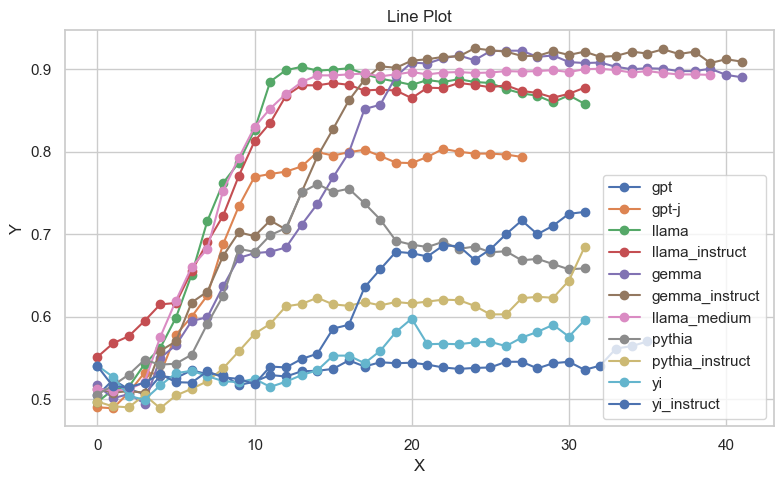

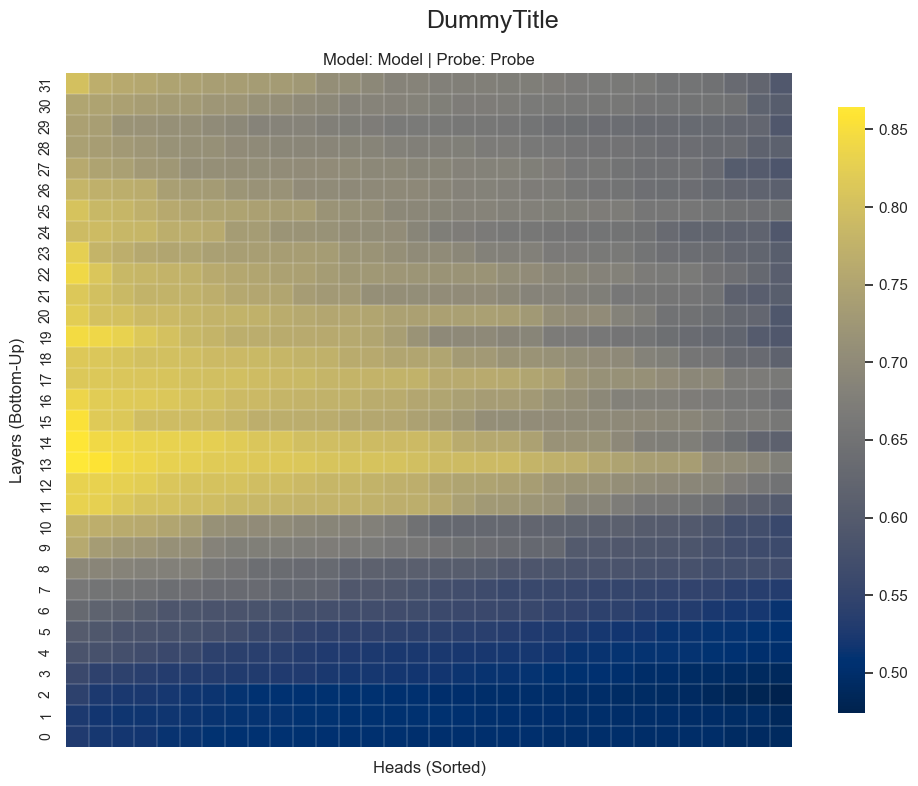

In [ ]:
PATH = Path('results_to_plot')
data_residual_full = []

models = ['gpt', 'gpt-j', 'llama', 'llama_instruct', 'gemma', 'gemma_instruct', 'llama_medium', 'pythia', 'pythia_instruct', 'yi', 'yi_instruct']

for model in models:
    data_residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
    data_residual_full.append(data_residual)

model = 'llama'
data_heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
data_residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
plot_line(data_residual_full, labels=models)
plot_heat(data_heads)

# USE

In [54]:
import os

model = 'llama_instruct'
folder = (PATH / model / 'USE')


for filename in os.listdir(folder):
    if filename.endswith("heads") or filename.endswith("residual"): 
        continue
    else:
        file_path = os.path.join(folder, filename)
        data = t.load(file_path)
        print(f"{filename}: {data}")

intervention_sweep_heads_20251223_105127: [[-0.44238389]]
intervention_sweep_heads_20251223_105850: [[-9.93016379e-05]]
intervention_sweep_heads_20251223_110808: [[-0.00102712]]
intervention_sweep_heads_20251223_115412: [[ 0.5723845   0.55554388  0.53703438  0.51644046  0.49441321]
 [ 0.15242578 -0.73705094 -0.97353039 -0.98099307 -0.97342858]
 [-0.06147312 -0.95842839 -0.96665825 -0.89994219 -0.75538596]
 [-0.16367309 -0.94521045 -0.80144698 -0.31094074 -0.04810906]
 [-0.51968346 -0.95755797 -0.7492332  -0.15304286 -0.00465545]]
intervention_sweep_heads_20251223_150223: [[-0.80890947]]
intervention_sweep_heads_20251223_153941: [[-0.77893561 -0.76634012 -0.75491346 -0.74167699 -0.71978331]
 [-0.80913743 -0.79556886 -0.78416586 -0.77186658 -0.75133805]
 [-0.83655984 -0.81805401 -0.80399803 -0.78882317 -0.76533596]
 [-0.8377742  -0.81853672 -0.804344   -0.7889264  -0.76554508]]
intervention_sweep_heads_20251223_195525: [[-1.67729104e-01 -1.64068699e-01 -1.59602490e-01 -1.54604988e-01
  -

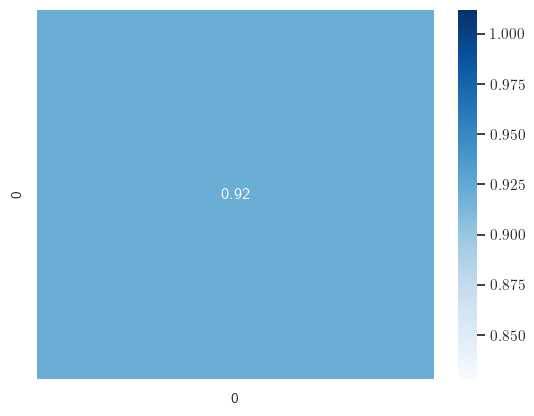

In [48]:
INTERVENTION_TYPE = 'residual'
model = 'gpt-j'
data_sweep = t.load(PATH / model / 'USE' / f"intervention_sweep_{INTERVENTION_TYPE}")
n_rows, n_cols = data_sweep.shape
fig, ax = plt.subplots()

# Set x and y ticks manually
ax.set_xticks(np.arange(n_cols) + 0.5)           # positions
ax.set_xticklabels([0 for _ in range(n_cols)])  # labels
ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels([0 for _ in range(n_rows)])

sns.heatmap(data_sweep, annot=True, cmap='Blues')  # annot=True shows the numbers
plt.show()

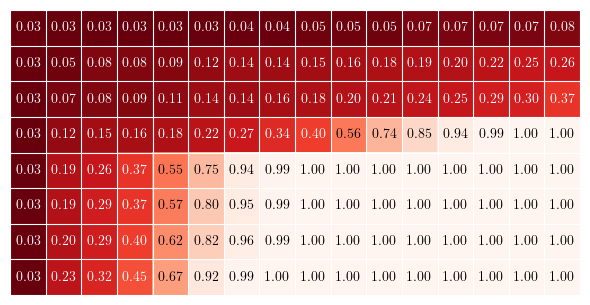

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- Configuration for ACL-style appearance ---
rcParams.update({
    "text.usetex": True,       # Use LaTeX for consistent fonts
    "font.family": "serif",    # Matches ACL paper font
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

# Slice first 10x10
data = np.array(data)
subset = data[:8, :16]

# --- Create figure ---
fig, ax = plt.subplots(figsize=(6, 4))  # compact square figure

cmap = plt.cm.Reds_r
im = ax.imshow(subset, cmap=cmap, interpolation='none', aspect='equal')

# Add subtle borders
for i in range(subset.shape[0] + 1):
    ax.axhline(i - 0.5, color='white', linewidth=0.8)
for j in range(subset.shape[1] + 1):
    ax.axvline(j - 0.5, color='white', linewidth=0.8)

# Annotations with automatic contrast
for i in range(subset.shape[0]):
    for j in range(subset.shape[1]):
        color = 'white' if subset[i, j] < 0.5 else 'black'
        ax.text(j, i, f"{subset[i, j]:.2f}", ha='center', va='center', color=color, fontsize=10)

# Remove axes for minimal look
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.tight_layout()
# --- Save as vector PDF for ACL submission ---
plt.savefig("heatmap_acl_style.pdf", bbox_inches='tight')
plt.show()


# COHERENCE

In [29]:
# Each path is different because I was messy

model = 'llama'
llama_data_dict = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp_self_report")

model = 'llama_instruct'
llama_instruct_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp")
llama_instruct_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
llama_instruct_data_dict = {**llama_instruct_data_dict_1, **llama_instruct_data_dict_2}

model = 'gpt-j'
gpt_j_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp")
gpt_j_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
gpt_j_data_dict = {**gpt_j_data_dict_1, **gpt_j_data_dict_2}

model = 'gemma'
gemma_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logistic_regression_mmp_logits")
gemma_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
gemma_data_dict = {**gemma_data_dict_1, **gemma_data_dict_2}

model = 'gemma_instruct'
gemma_instruct_data_dict_1 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_logits_logistic_regression_mmp")
gemma_instruct_data_dict_2 = t.load(PATH / model / 'COHERENCE' / f"coherence_scoresnegorand_self_report")
gemma_instruct_data_dict = {**gemma_instruct_data_dict_1, **gemma_instruct_data_dict_2}



In [61]:
from collections import OrderedDict

key_order = ['logistic_regression', 'mmp', 'self_report', 'logits']

def make_ordered_custom(d, order):
    """
    Recursively convert nested dicts into OrderedDicts
    following a custom key order.
    """
    if isinstance(d, dict):
        od = OrderedDict()
        for k in order:
            if k in d:
                od[k] = make_ordered_custom(d[k], order)
        # Add any keys not in the custom order at the end
        for k in d:
            if k not in order:
                od[k] = make_ordered_custom(d[k], order)
        return od
    elif isinstance(d, (list, tuple)):
        return type(d)(make_ordered_custom(x, order) if isinstance(x, dict) else x for x in d)
    else:
        return d

# Example: convert your data
dicts = [llama_data_dict, llama_instruct_data_dict, gpt_j_data_dict, gemma_data_dict, gemma_instruct_data_dict]
data_ordered = [make_ordered_custom(d, key_order) for d in dicts]

In [123]:
data_ordered[0]['logistic_regression']

OrderedDict([('neg',
              (tensor(0.8406, dtype=torch.float64),
               tensor(0.7642, dtype=torch.float64))),
             ('or', (tensor(0.7754), 0.5)),
             ('and', (tensor(0.8359), 0.5))])

OrderedDict([('logistic_regression', OrderedDict([('neg', (tensor(0.7099, dtype=torch.float64), tensor(0.7535, dtype=torch.float64))), ('or', (tensor(0.7896), 0.5)), ('and', (tensor(0.8164), 0.5))])), ('mmp', OrderedDict([('neg', (tensor(0.5192), tensor(0.5213))), ('or', (tensor(0.9766), 0.5)), ('and', (tensor(0.9990), 0.5))])), ('self_report', OrderedDict([('neg', (tensor(0.5607), tensor(0.5619))), ('or', (tensor(0.9395), 0.5)), ('and', (tensor(0.9727), 0.5))])), ('logits', OrderedDict([('neg', (tensor(0.8629, dtype=torch.float64), tensor(0.8679, dtype=torch.float64))), ('or', (tensor(0.0640), 0.5)), ('and', (tensor(0.8818), 0.5))]))])


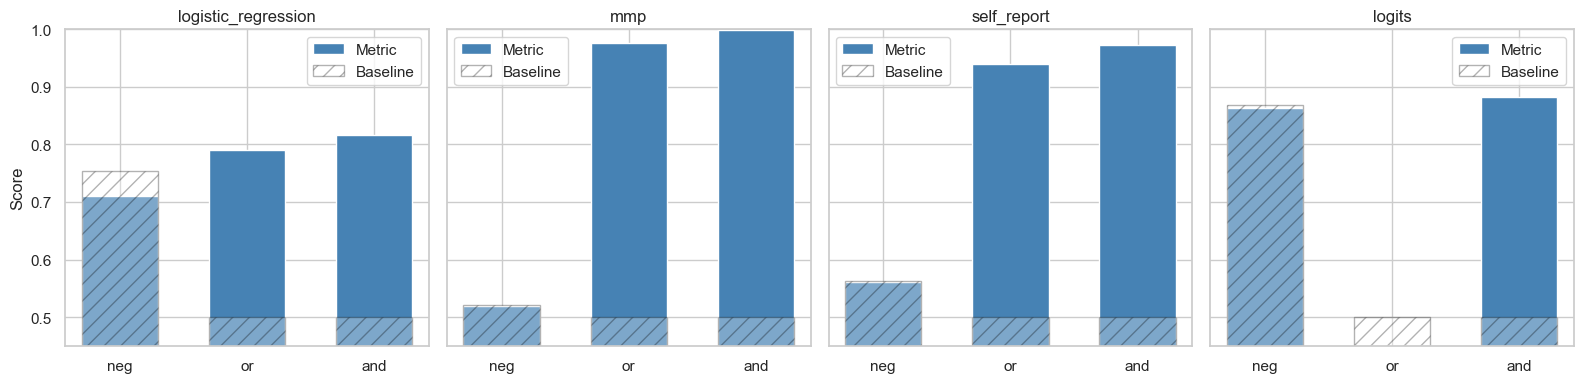

In [149]:
model = 'gpt-j'

order = ['llama', 'llama_instruct', 'gpt-j', 'gemma', 'gemma_instruct']

data = data_ordered[order.index(model)]

print(data)

tests = ['neg', 'or', 'and']
models = list(data.keys())
bar_width = 0.6

fig, axes = plt.subplots(1, len(models), figsize=(16,4), sharey=True)

for i, model in enumerate(models):
    metrics = [data[model][t][0] for t in tests]
    baselines = [data[model][t][1] for t in tests]
    
    x = np.arange(len(tests))
    
    # Plot baseline first
    # Plot metric on top
    axes[i].bar(x, metrics, color='steelblue', width=bar_width, label='Metric')
    axes[i].bar(x, baselines, color='white', width=bar_width, label='Baseline', alpha=0.3, edgecolor='black', hatch='//')
    
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(tests)
    axes[i].set_title(model)
    axes[i].grid(True)
    axes[i].set_ylim(0.45, 1.0)
    
    if i == 0:
        axes[i].set_ylabel('Score')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [25]:
print(data_dict, data_dict_self)


{'logits': {'neg': (tensor(0.8985, dtype=torch.float64), tensor(0.8079, dtype=torch.float64)), 'or': (tensor(0.7393), 0.5), 'and': (tensor(0.4741), 0.5)}, 'logistic_regression': {'neg': (tensor(0.7324, dtype=torch.float64), tensor(0.7080, dtype=torch.float64)), 'or': (tensor(0.7925), 0.5), 'and': (tensor(0.8516), 0.5)}, 'mmp': {'neg': (tensor(0.7510), tensor(0.7137)), 'or': (tensor(0.8091), 0.5), 'and': (tensor(0.8496), 0.5)}} {'self_report': {'neg': (tensor(0.8112), tensor(0.7456)), 'or': (tensor(0.9062), 0.5), 'and': (tensor(0.8149), 0.5)}}


# UNIFORMITY

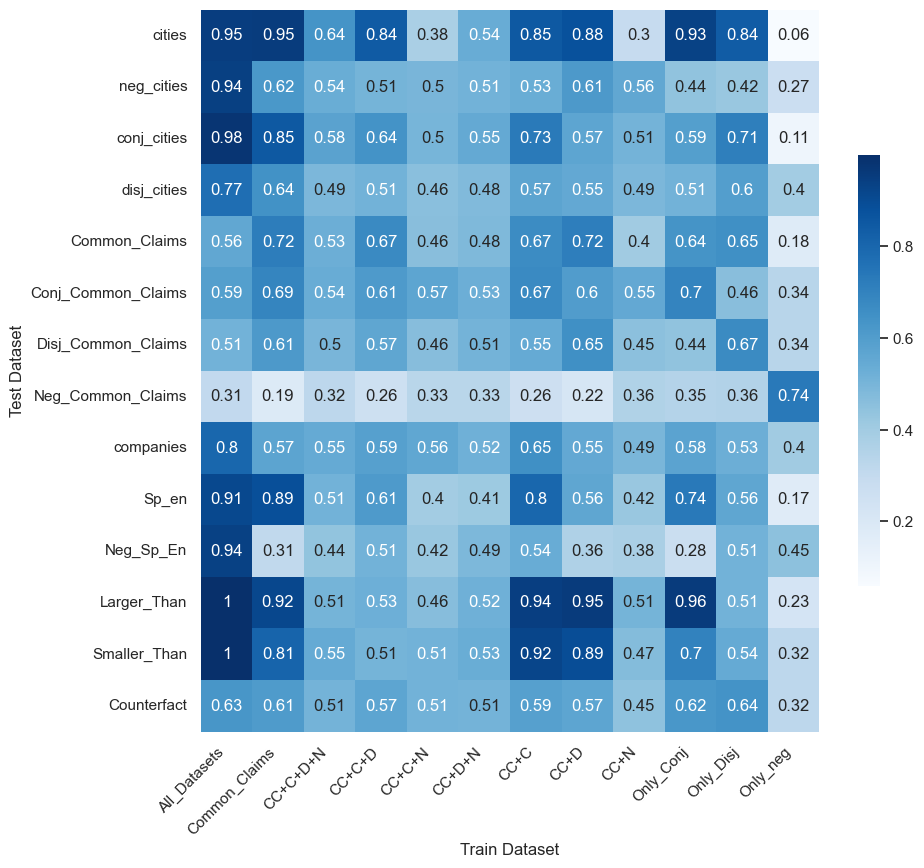

In [227]:
model = 'llama_instruct'
UNIF_TYPE = 'logic'

if UNIF_TYPE == 'domain':
    x_ticks = ['All_Datasets', 'Common_Claims', 'CC+Cities', 'cities', 'CC+Companies', 'companies', 'CC+Sp_en', 'Sp_en', 'CC+Larger_Than', 'Larger_than', 'CC+Counterfact', 'Counterfact']
    y_ticks = ['cities', 'Common_Claims', 'companies', 'Sp_En', 'Larger_Than', 'Counterfact']

elif UNIF_TYPE == 'logic':
    x_ticks = ['All_Datasets', 'Common_Claims', 'CC+C+D+N', 'CC+C+D', 'CC+C+N', 'CC+D+N', 'CC+C', 'CC+D', 'CC+N', 'Only_Conj', 'Only_Disj', 'Only_neg']
    y_ticks = ['cities', 'neg_cities', 'conj_cities', 'disj_cities', 'Common_Claims', 'Conj_Common_Claims', 'Disj_Common_Claims', 'Neg_Common_Claims', 'companies', 'Sp_en', 'Neg_Sp_En', 'Larger_Than', 'Smaller_Than', 'Counterfact']

else:
    raise ValueError("You messed up. Have an error")

# Your data loading code remains the same
data_sweep = t.load(PATH / model / 'UNIFORMITY' / f"uniformity_uniformity{UNIF_TYPE}")
data_sweep = np.array([[data_sweep[row][col][0] for col in sorted(data_sweep[row])] for row in sorted(data_sweep)]).T

n_rows, n_cols = data_sweep.shape

# Make figure bigger
fig, ax = plt.subplots(figsize=(10, 10))  # adjust size as needed

sns.heatmap(data_sweep, annot=True, cmap='Blues',
            xticklabels=x_ticks, yticklabels=y_ticks,
            square=True, ax=ax, cbar_kws={'shrink': 0.5})

# Rotate ticks
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Caption axes
ax.set_xlabel("Train Dataset")
ax.set_ylabel("Test Dataset")

plt.tight_layout()
plt.show()


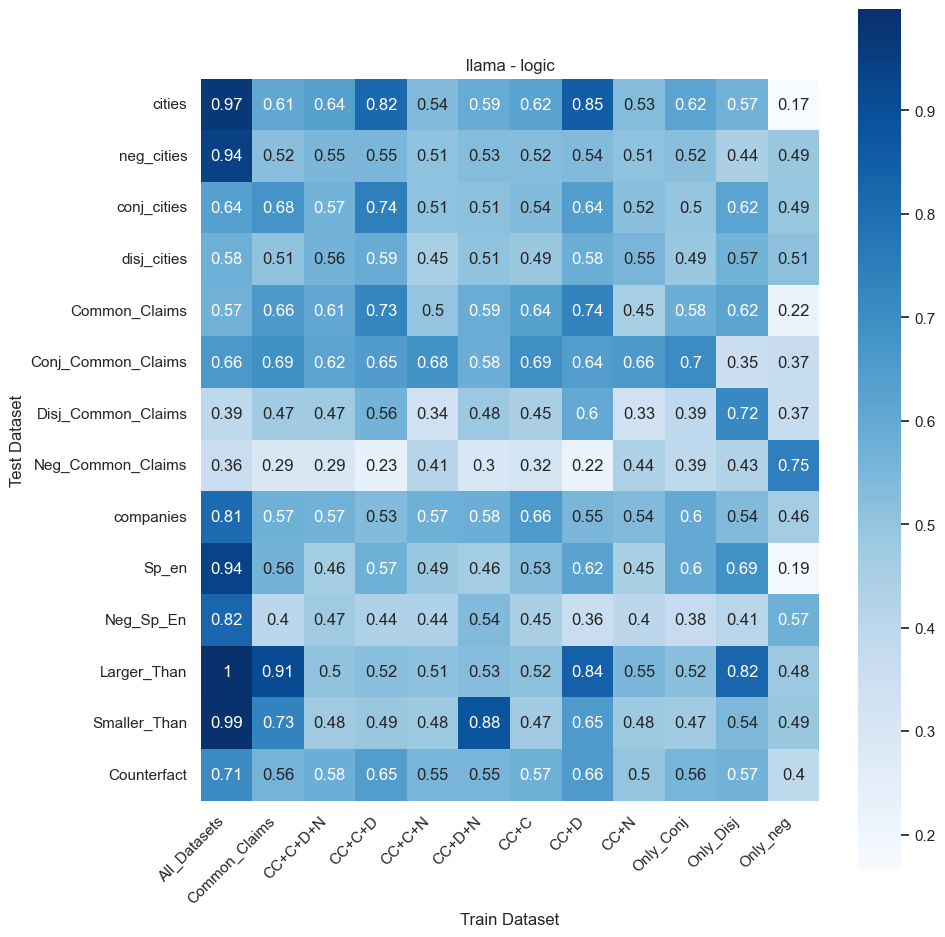

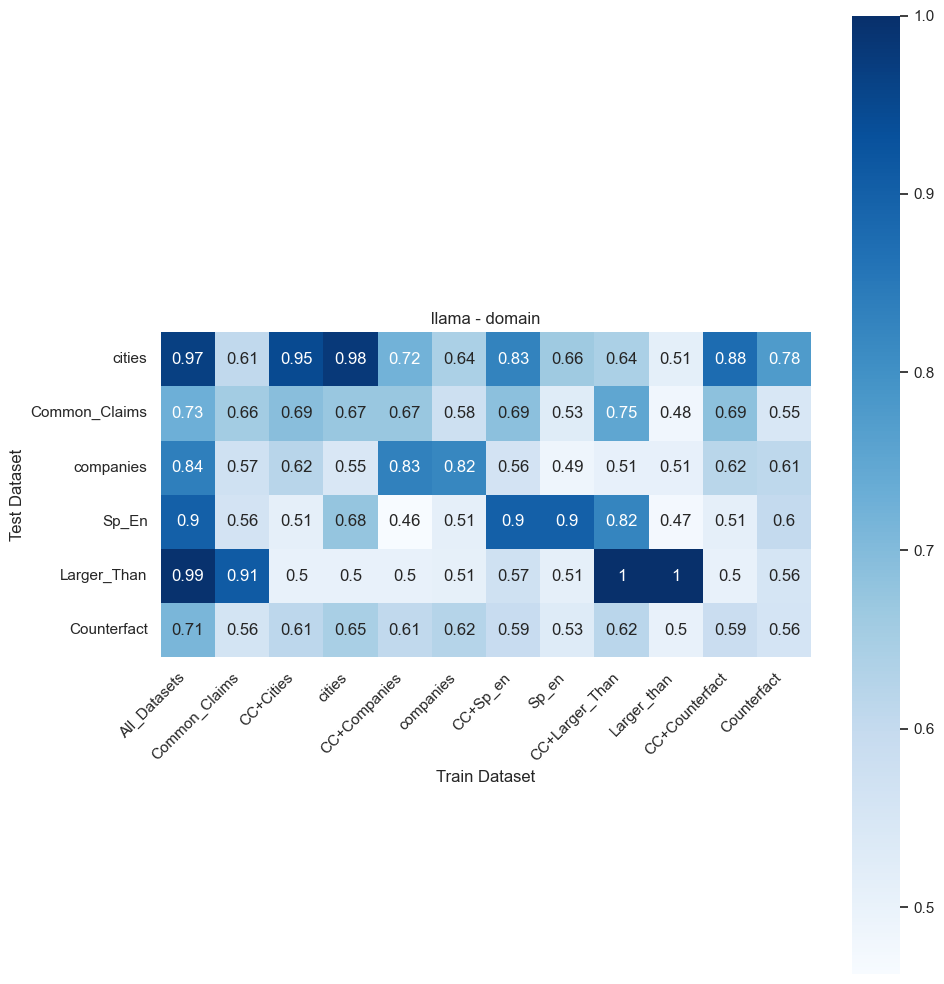

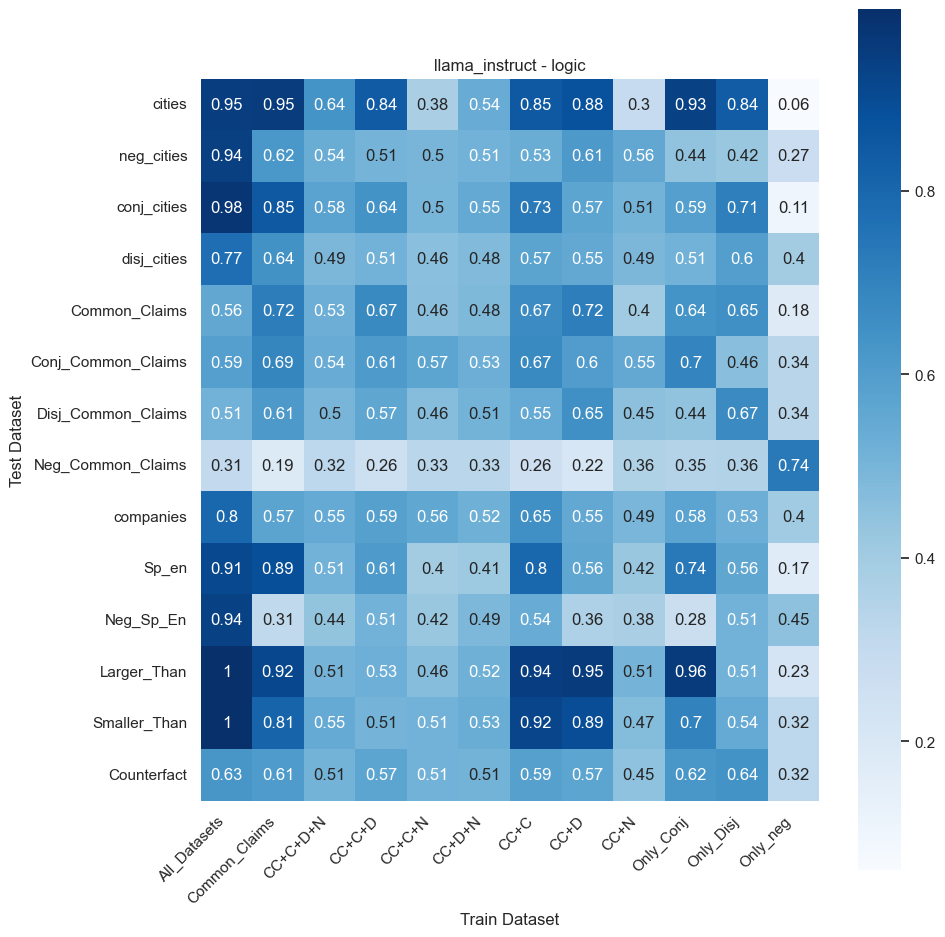

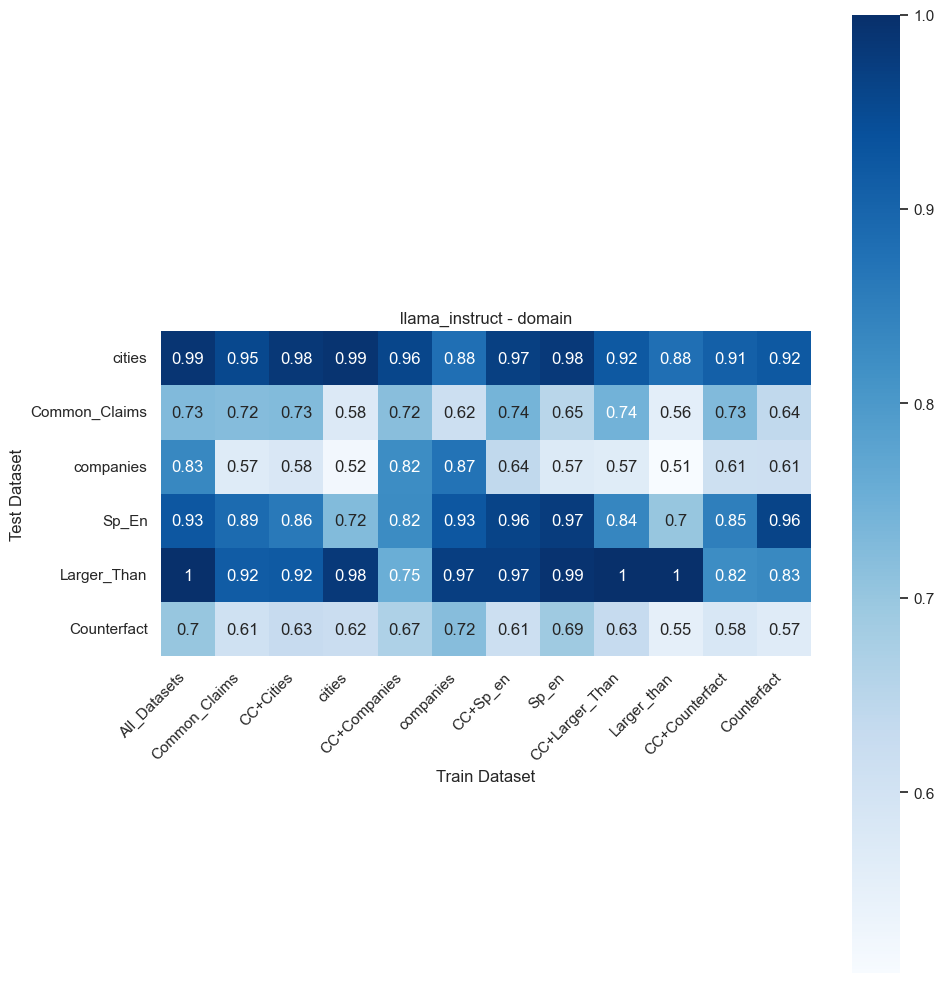

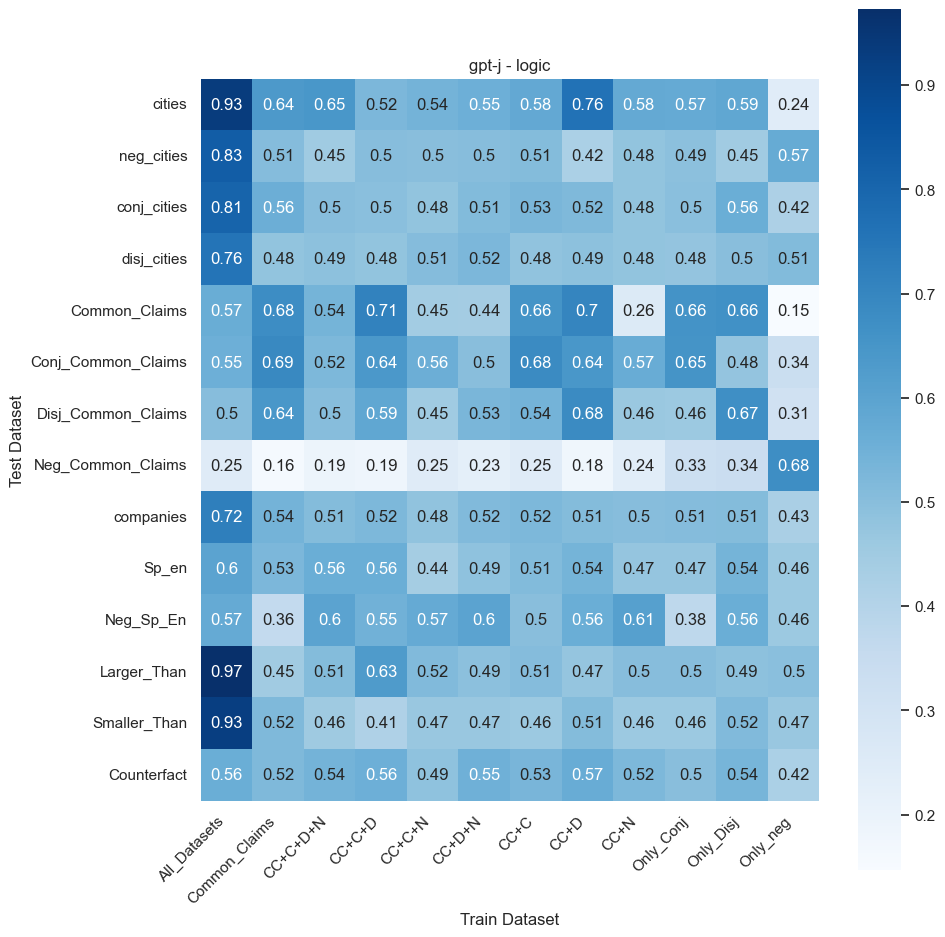

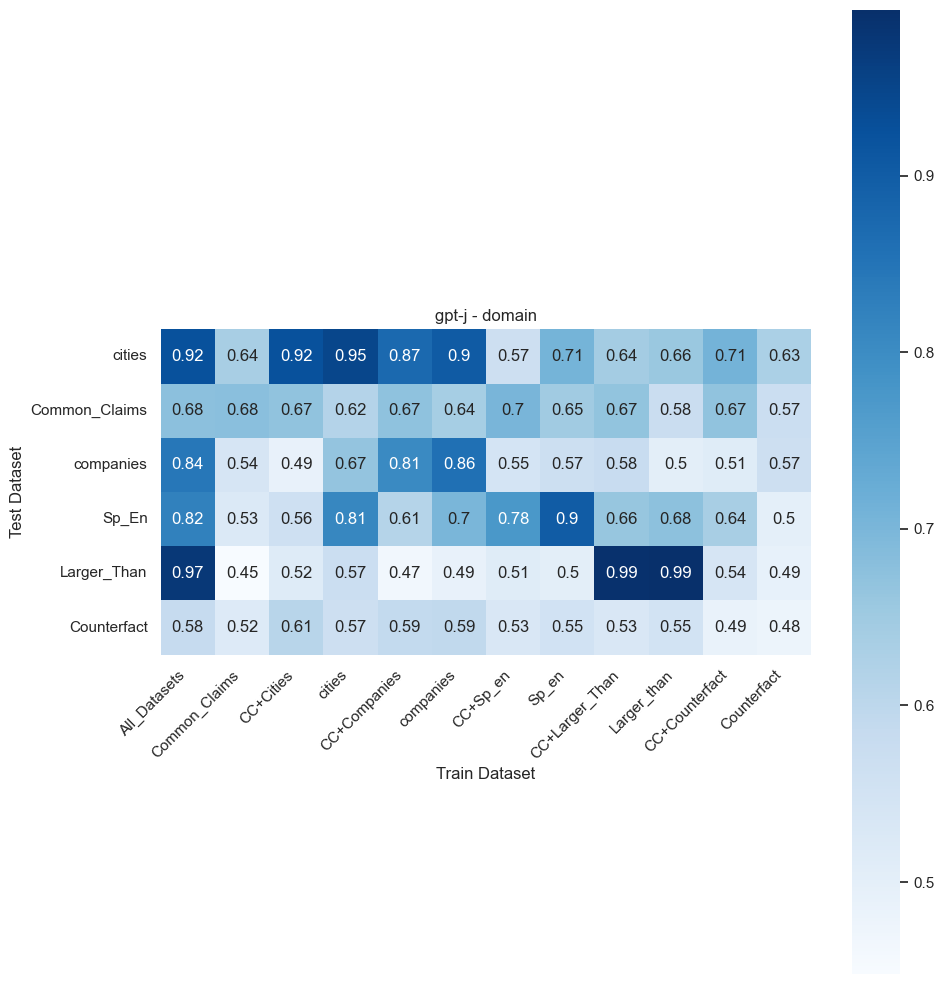

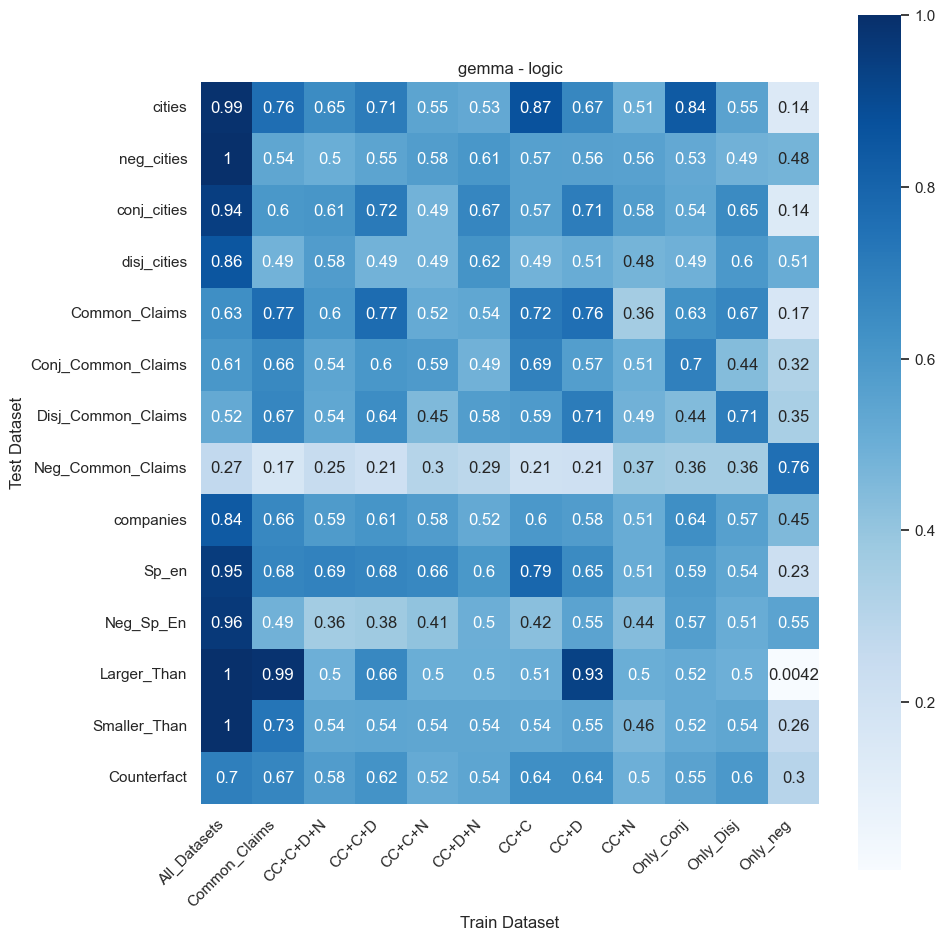

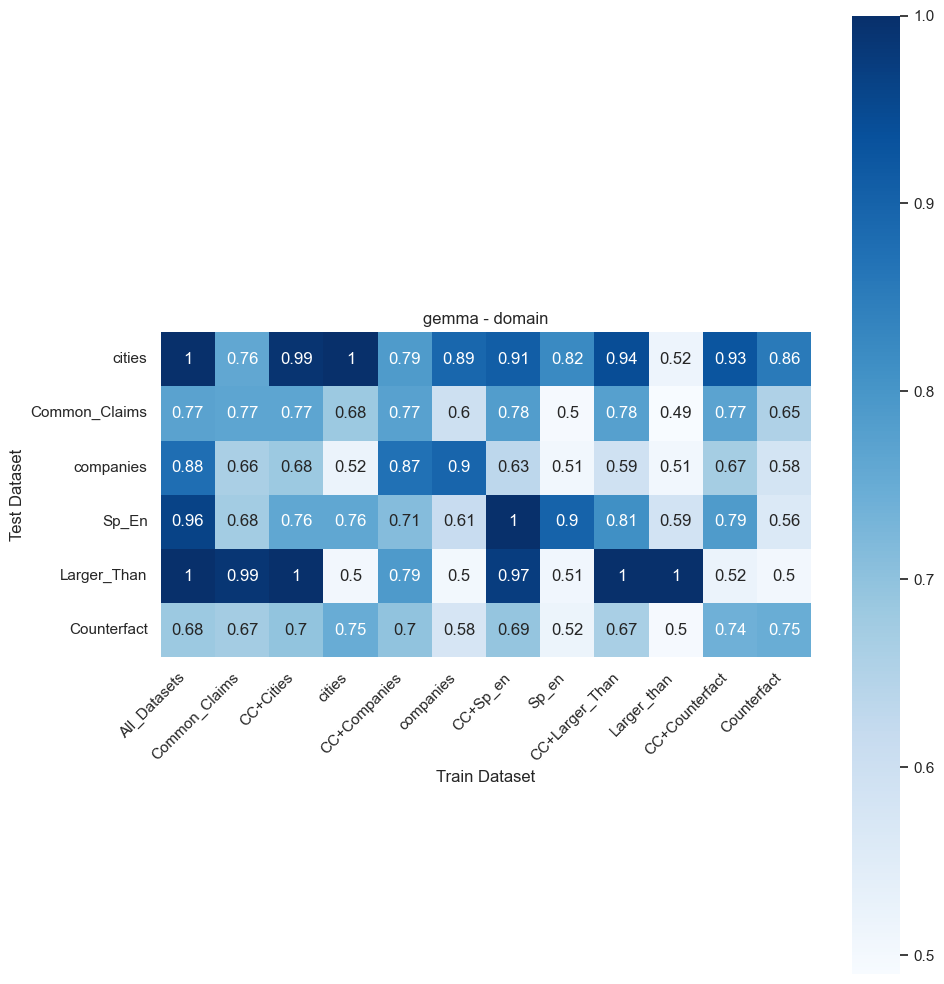

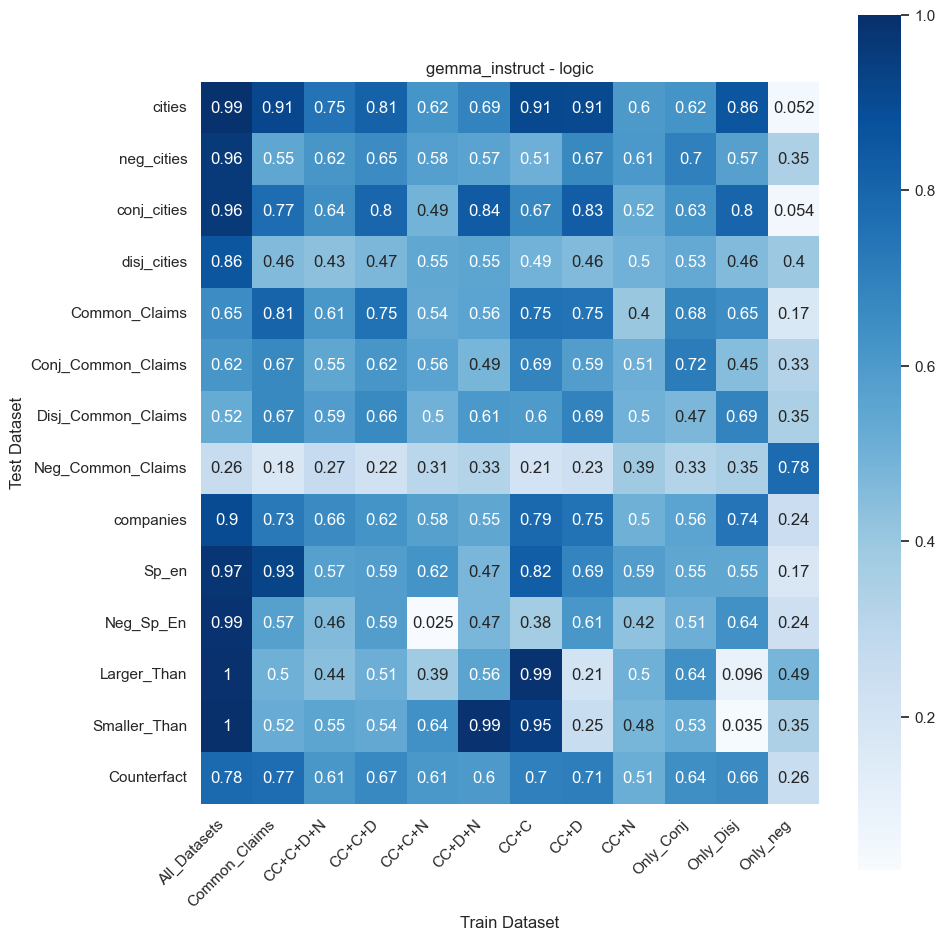

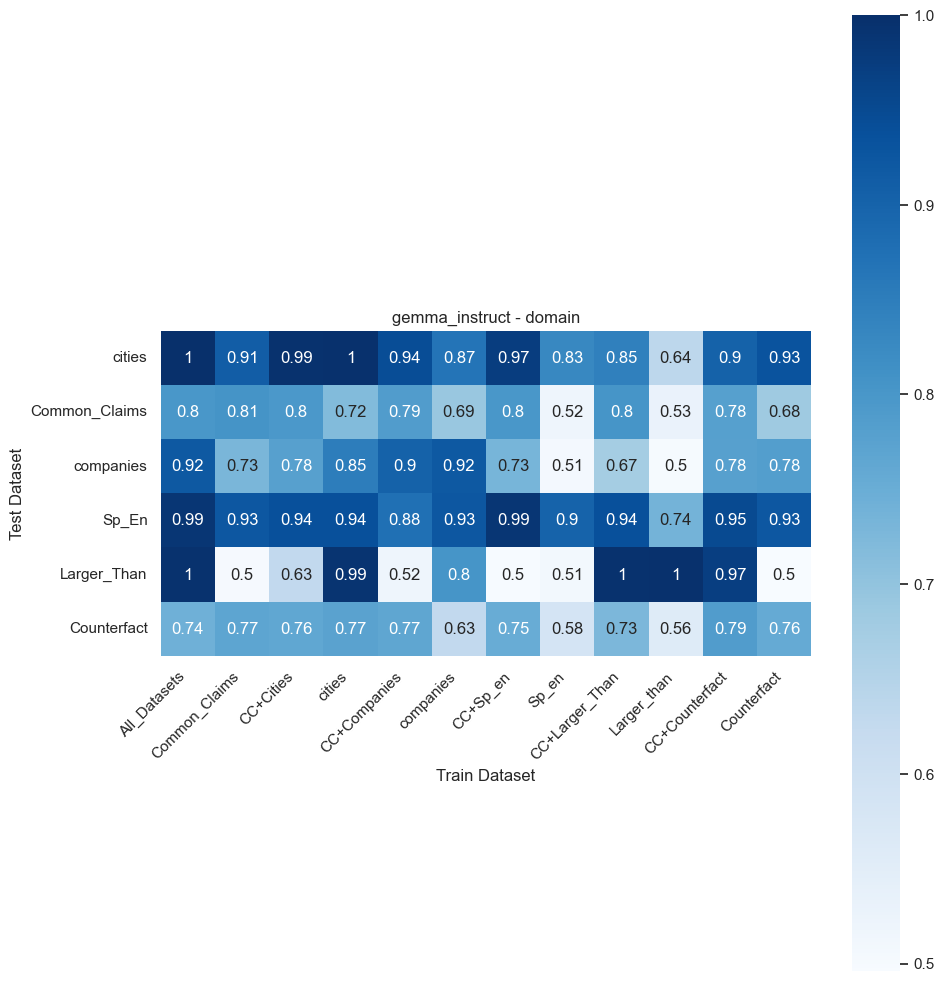

In [233]:
import torch as t
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

PATH = Path("results_to_plot")

models = ['llama', 'llama_instruct', 'gpt-j', 'gemma', 'gemma_instruct']
unif_types = ['logic', 'domain']

# Container for all matrices
matrices = {}

for model in models:
    matrices[model] = {}
    for UNIF_TYPE in unif_types:
        # Set x_ticks and y_ticks per UNIF_TYPE
        if UNIF_TYPE == 'domain':
            x_ticks = ['All_Datasets', 'Common_Claims', 'CC+Cities', 'cities', 'CC+Companies', 'companies', 
                       'CC+Sp_en', 'Sp_en', 'CC+Larger_Than', 'Larger_than', 'CC+Counterfact', 'Counterfact']
            y_ticks = ['cities', 'Common_Claims', 'companies', 'Sp_En', 'Larger_Than', 'Counterfact']

        elif UNIF_TYPE == 'logic':
            x_ticks = ['All_Datasets', 'Common_Claims', 'CC+C+D+N', 'CC+C+D', 'CC+C+N', 'CC+D+N', 
                       'CC+C', 'CC+D', 'CC+N', 'Only_Conj', 'Only_Disj', 'Only_neg']
            y_ticks = ['cities', 'neg_cities', 'conj_cities', 'disj_cities', 'Common_Claims', 'Conj_Common_Claims',
                       'Disj_Common_Claims', 'Neg_Common_Claims', 'companies', 'Sp_en', 'Neg_Sp_En', 
                       'Larger_Than', 'Smaller_Than', 'Counterfact']
        else:
            raise ValueError("UNIF_TYPE not recognized")

        # Load the data
        data_sweep = t.load(PATH / model / 'UNIFORMITY' / f"uniformity_uniformity{UNIF_TYPE}")
        data_array = np.array([[data_sweep[row][col][0] for col in sorted(data_sweep[row])] 
                               for row in sorted(data_sweep)]).T

        # Store the full matrix
        matrices[model][UNIF_TYPE] = data_array

        # Optional: visualize
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(data_array, annot=True, cmap='Blues', xticklabels=x_ticks, yticklabels=y_ticks, square=True, ax=ax)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        ax.set_xlabel("Train Dataset")
        ax.set_ylabel("Test Dataset")
        plt.title(f"{model} - {UNIF_TYPE}")
        plt.tight_layout()
        plt.show()

# 'matrices' now contains all 10 full matrices
# Access example: matrices['llama_instruct']['logic']


In [235]:
matrices_logic = {model: matrices[model]['logic'] for model in models}
matrices_domain = {model: matrices[model]['domain'] for model in models}

# FINAL SCORES

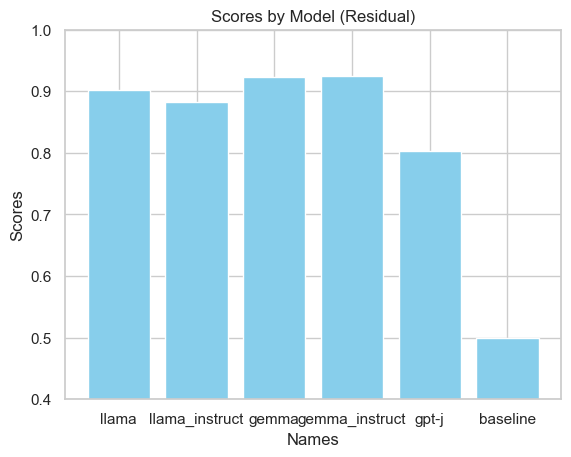

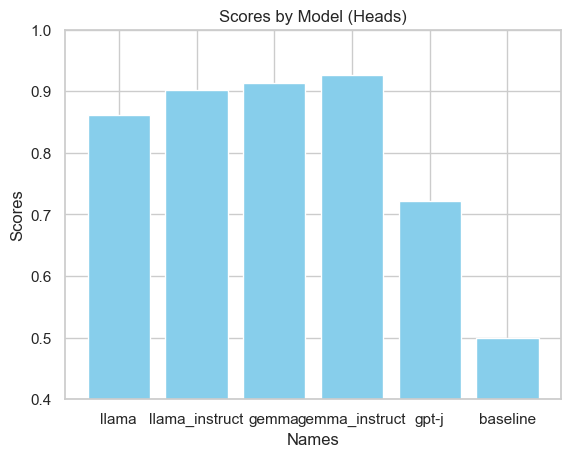

In [215]:
def score_accuracy(data, top_k=None):
    
    data = t.tensor(data) if not isinstance(data, t.Tensor) else data
    if top_k is not None:
        # Flatten to 1D and select top-k
        top_values = t.topk(data.flatten(), top_k).values
        score = top_values.mean().item()
    else:
        score = data.mean().item()
    return score

top_k = 3
model = 'llama'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
llama_score_r = score_accuracy(residual, top_k=top_k)
llama_score_h = score_accuracy(heads, top_k=top_k)
model = 'llama_instruct'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
llama_instruct_score_r = score_accuracy(residual, top_k=top_k)
llama_instruct_score_h = score_accuracy(heads, top_k=top_k)
model = 'gemma'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
gemma_score_r = score_accuracy(residual, top_k=top_k)
gemma_score_h = score_accuracy(heads, top_k=top_k)
model = 'gemma_instruct'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
gemma_instruct_score_r = score_accuracy(residual, top_k=top_k)
gemma_instruct_score_h = score_accuracy(heads, top_k=top_k)
model = 'gpt-j'
heads = t.load(PATH / model / 'ACCURACY' / 'accuracies_heads')
residual = t.load(PATH / model / 'ACCURACY' / 'accuracies_residual')
gpt_j_score_r = score_accuracy(residual, top_k=top_k)
gpt_j_score_h = score_accuracy(heads, top_k=top_k)

results_accuracy_residual = {
    'llama': llama_score_r,
    'llama_instruct': llama_instruct_score_r,
    'gemma': gemma_score_r,
    'gemma_instruct': gemma_instruct_score_r,
    'gpt-j': gpt_j_score_r,
    'baseline': 0.5
}

results_accuracy_heads = {
    'llama': llama_score_h,
    'llama_instruct': llama_instruct_score_h,
    'gemma': gemma_score_h,
    'gemma_instruct': gemma_instruct_score_h,
    'gpt-j': gpt_j_score_h,
    'baseline': 0.5
}    

plt.bar(results_accuracy_residual.keys(), results_accuracy_residual.values(), color='skyblue')
plt.xlabel('Names')
plt.ylabel('Scores')
plt.title('Scores by Model (Residual)')
plt.ylim(0.4, 1)
plt.show()
plt.bar(results_accuracy_heads.keys(), results_accuracy_heads.values(), color='skyblue')
plt.xlabel('Names')
plt.ylabel('Scores')
plt.title('Scores by Model (Heads)')
plt.ylim(0.4, 1)
plt.show()

In [ ]:
# Should take in data as (N(Correct), N(Flipped), Strength, k, alpha...)

def score_intervention(data):
    
    success = data[1] - data[0]     # Flipped answers
    strength = data[2]              # Alpha * K / d_model

    relative_success = success / strength if strength != 0 else 0

    return 1 / (1 + relative_success)

In [ ]:
# Takes in a cross-domain/cross-logic matrix

def score_uniformity(matrix):
    matrix = np.array(matrix)
    
    # Overall score
    overall_score = np.mean(matrix) - np.std(matrix)
    
    # First column score
    first_col = matrix[:, 0]
    first_col_score = np.mean(first_col) - np.std(first_col)
    
    return overall_score, first_col_score


In [256]:
llama_unif = score_uniformity(matrices_domain['llama']) 
llama_instruct_unif = score_uniformity(matrices_domain['llama_instruct'])
gpt_j_unif = score_uniformity(matrices_domain['gpt-j'])
gemma_unif = score_uniformity(matrices_domain['gemma'])
gemma_instruct_unif = score_uniformity(matrices_domain['gemma_instruct'])

domain_scores = {
    "llama": llama_unif,
    "llama_instruct": llama_instruct_unif,
    "gpt_j": gpt_j_unif,
    "gemma": gemma_unif,
    "gemma_instruct": gemma_instruct_unif
}

for model, score in domain_scores.items():
    print(model, "\ngeneral", score[0], "all_datasets", score[1])

llama 
general 0.5060460867301433 all_datasets 0.747667177367418
llama_instruct 
general 0.6273841045124473 all_datasets 0.7440517758617988
gpt_j 
general 0.5057649197070717 all_datasets 0.6697445155165004
gemma 
general 0.5757640961829853 all_datasets 0.7630370675660534
gemma_instruct 
general 0.6414518582301165 all_datasets 0.8071401826715009


In [257]:
# Takes in a cross-logic matrix

llama_coherence_1 = score_uniformity(matrices_logic['llama']) 
llama_instruct_coherence_1 = score_uniformity(matrices_logic['llama_instruct'])
gpt_j_coherence_1 = score_uniformity(matrices_logic['gpt-j'])
gemma_coherence_1 = score_uniformity(matrices_logic['gemma'])
gemma_instruct_coherence_1 = score_uniformity(matrices_logic['gemma_instruct'])

coherence_scores = {
    "llama": llama_coherence_1,
    "llama_instruct": llama_instruct_coherence_1,
    "gpt_j": gpt_j_coherence_1,
    "gemma": gemma_coherence_1,
    "gemma_instruct": gemma_instruct_coherence_1
}

for model, score in coherence_scores.items():
    print(model, "\ngeneral", score[0], "all_datasets", score[1])

llama 
general 0.4031002976693211 all_datasets 0.5318043842582401
llama_instruct 
general 0.36961754379750555 all_datasets 0.5648162507072334
gpt_j 
general 0.38601121711885966 all_datasets 0.4877322158634759
gemma 
general 0.3874629960165311 all_datasets 0.5869364175167491
gemma_instruct 
general 0.36699448959868824 all_datasets 0.6014197270555243


In [226]:
logreg_data = [x['logistic_regression'] for x in data_ordered]

# Pass in logistic_regression coherence scores. Everything will be shifted by 0.5 for readability

def score_coherence_2(data):

    diffs = [v[0]-v[1] for v in data.values()]
   
    return np.mean(diffs) + 0.5

model_scores_coherence_2 = []

for model in logreg_data:
    model_scores_coherence_2.append(score_coherence_2(model))

model_scores_coherence_2.append(0.5)
models = ['llama', 'llama_instruct', 'gpt-j', 'gemma', 'gemma_instruct', 'baselines']

for model in models:
    print(f"{model}: {model_scores_coherence_2[models.index(model)]}")
    

llama: 0.7292441740094411
llama_instruct: 0.7228257873714022
gpt-j: 0.6874627389526491
gemma: 0.7165847963908243
gemma_instruct: 0.7287662602402427
baselines: 0.5


In [127]:
logreg_data[0]

OrderedDict([('neg',
              (tensor(0.8406, dtype=torch.float64),
               tensor(0.7642, dtype=torch.float64))),
             ('or', (tensor(0.7754), 0.5)),
             ('and', (tensor(0.8359), 0.5))])

In [ ]:
import plotly.graph_objects as go

# Example normalized data
benchmarks = ['Accuracy', 'Use', 'Coherence 1', 'Coherence 2', 'Uniformity']
model_scores = {
    'Llama': [0.91, 0.90, 0.6, 0.9, 0.7],
    'Llama-It': [0.90, 1, 0.7, 0.9, 0.6],
    'Gemma': [0.93, 0.94, 0.8, 0.7, 0.8],
    'Gemma-It': [0.93, 0.95, 0.82, 0.9, 0.5],
    'GPT-J': [0.78, 0.6, 0.5, 0.5, 0.55],
}

fig = go.Figure()

for model, scores in model_scores.items():
    fig.add_trace(go.Scatterpolar(
        r=scores + [scores[0]],  # close the circle
        theta=benchmarks + [benchmarks[0]],
        fill='none',  # no fill for clarity
        name=model
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0.5, 1])
    ),
    showlegend=True,
    title="Model Benchmark Radar Chart"
)

fig.show()
